# Imports

In [1]:
import os
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
from tensorflow.keras.applications import DenseNet121
from tensorflow import keras
from keras import layers
from tensorflow.keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Loading images

In [ ]:
train_fake = 'dataset/train/Fake'
train_real = 'dataset/train/Real'

train_dir = [train_real, train_fake] 

val_fake = 'dataset/val/Fake'
val_real = 'dataset/val/Real'

val_dir = [val_real, val_fake]

test_fake = 'dataset/test/Fake'
test_real = 'dataset/test/Real'

test_dir = [test_real, test_fake]

# Preprocessing

> Function: Error-level Analysis (ELA)

In [3]:
def ela(im_path):

  im = Image.open(im_path).convert('RGB')

  if im.size != (224, 224):
    im = im.resize((224, 224))

  im_temp = 'temp.jpg'
  im.save(im_temp, 'JPEG', quality=90)
  resaved = Image.open(im_temp)

  diff = ImageChops.difference(im, resaved)
  extrema = diff.getextrema()
  max_px = max([ex[1] for ex in extrema])
  scale_factor = 255.0 / max_px if max_px != 0 else 1
  diff = ImageEnhance.Brightness(diff).enhance(scale_factor)

  os.remove(im_temp)
  return diff

> Function: Labeler

In [4]:
def labeler(im_dir, ela_bool):
    X, Y = [], []
    for dir_path in im_dir:
        for name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, name)
            if ela_bool:
                im = ela(file_path)
            else:
                im = Image.open(file_path).convert('RGB').resize((224, 224))
            if name.startswith("real"):
                X.append(im)
                Y.append(1)
            elif name.startswith("fake"):
                X.append(im)
                Y.append(0)
    return np.array(X).astype('float32') / 255.0, np.array(Y).astype('int')

> Assign X, Y

In [ ]:
X_train_ela, Y_train_ela = labeler(train_dir, True)

In [6]:
X_val_ela, Y_val_ela = labeler(val_dir, True)

In [7]:
X_test_ela, Y_test_ela = labeler(test_dir, True)

In [6]:
X_train, Y_train = labeler(train_dir, False)

In [7]:
X_val, Y_val = labeler(val_dir, False)

In [8]:
X_test, Y_test = labeler(test_dir, False)

> Function: Verify images and labels were correctly loaded

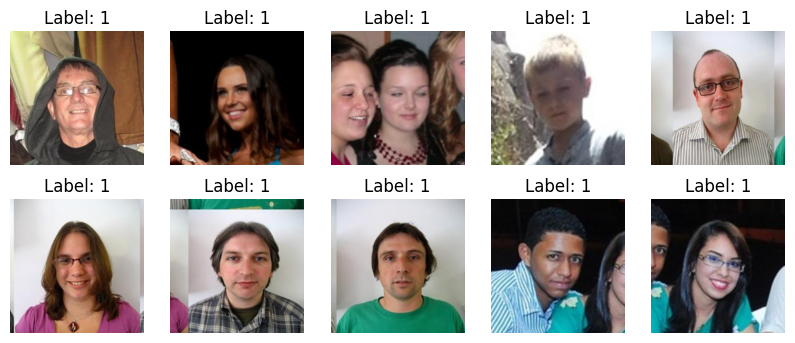

In [11]:
def display_samples(X_train, Y_train, num_samples):
    plt.figure(figsize=(num_samples, 4))
    for i in range(num_samples):
        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(X_train[i])  
        plt.title(f"Label: {Y_train[i]}")
        plt.axis("off")
    plt.show()

display_samples(X_train, Y_train, num_samples=10)


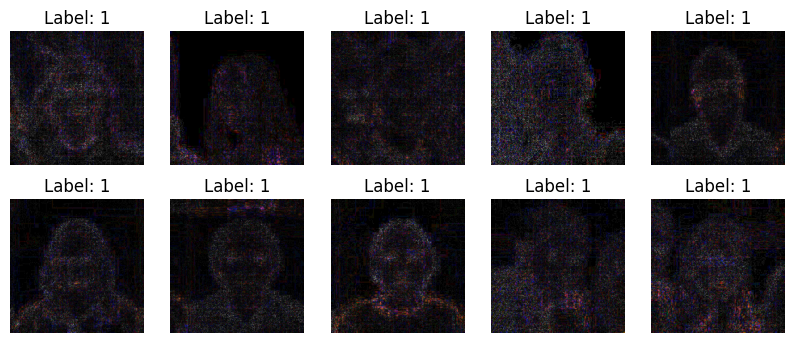

In [12]:
display_samples(X_train_ela, Y_train_ela, num_samples=10)

> Function: Shuffle array to avoid bias

In [9]:
def shuffler(arr1, arr2):
  shuffle = np.arange(arr1.shape[0])
  np.random.shuffle(shuffle)
  return arr1[shuffle], arr2[shuffle]

In [14]:
X_test_ela, Y_test_ela = shuffler(X_test_ela, Y_test_ela)
X_val_ela, Y_val_ela = shuffler(X_val_ela, Y_val_ela)
X_train_ela, Y_train_ela = shuffler(X_train_ela, Y_train_ela)

In [10]:
X_test, Y_test = shuffler(X_test, Y_test)
X_val, Y_val = shuffler(X_val, Y_val)
X_train, Y_train = shuffler(X_train, Y_train)

> Verify shuffled array

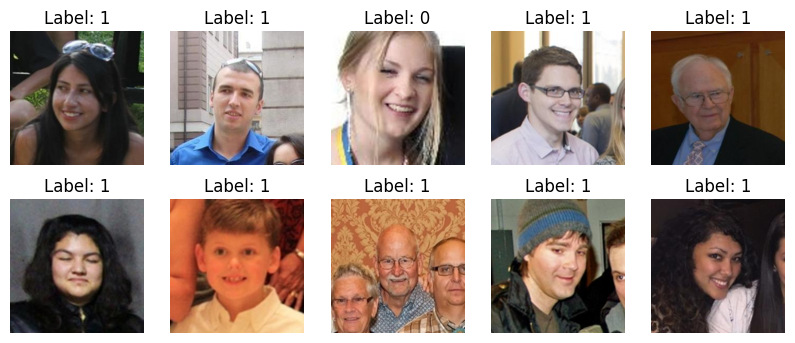

In [16]:
display_samples(X_train, Y_train, num_samples=10)

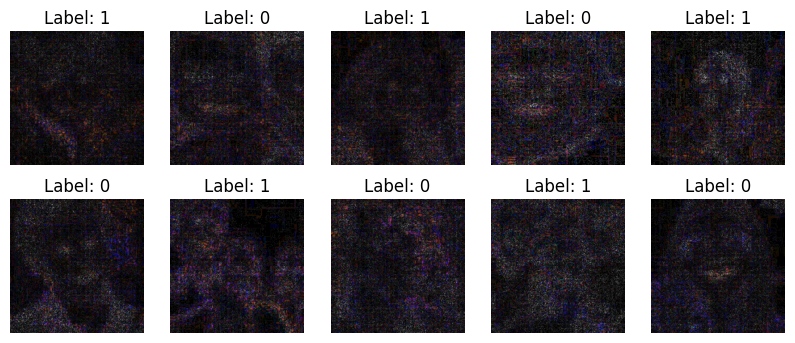

In [17]:
display_samples(X_train_ela, Y_train_ela, num_samples=10)

> Check distribution before modelling

In [13]:
def check_class_distribution(Y, title):
    
    Y = pd.Series(Y).replace({0: "Fake", 1: "Real"})
    distribution = Y.value_counts()

    plt.figure(figsize=(8, 6))
    distribution.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.ylim(0, 4000)
    plt.show()

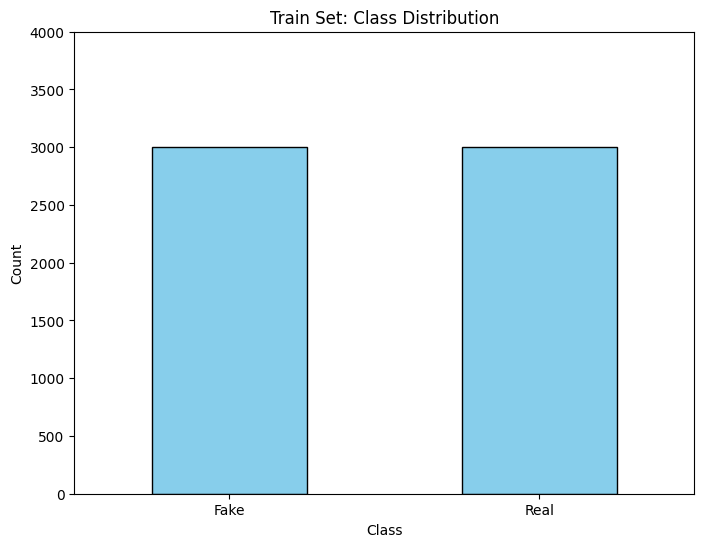

In [14]:
check_class_distribution(Y_train,"Train Set: Class Distribution")

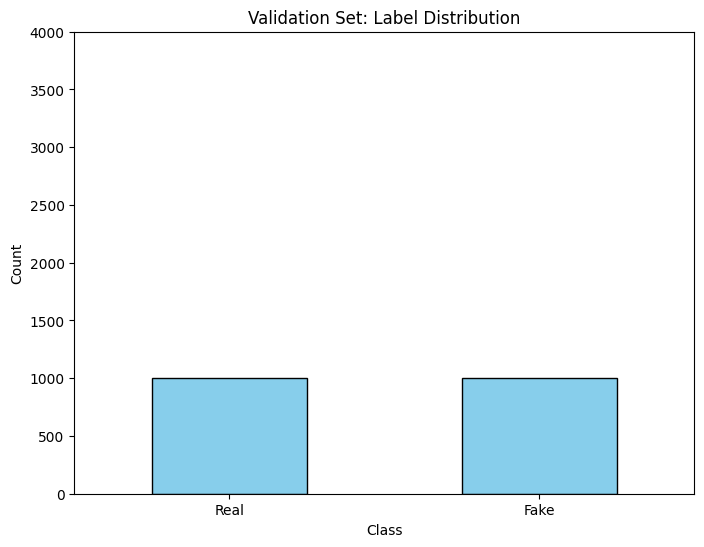

In [15]:
check_class_distribution(Y_val, "Validation Set: Label Distribution")

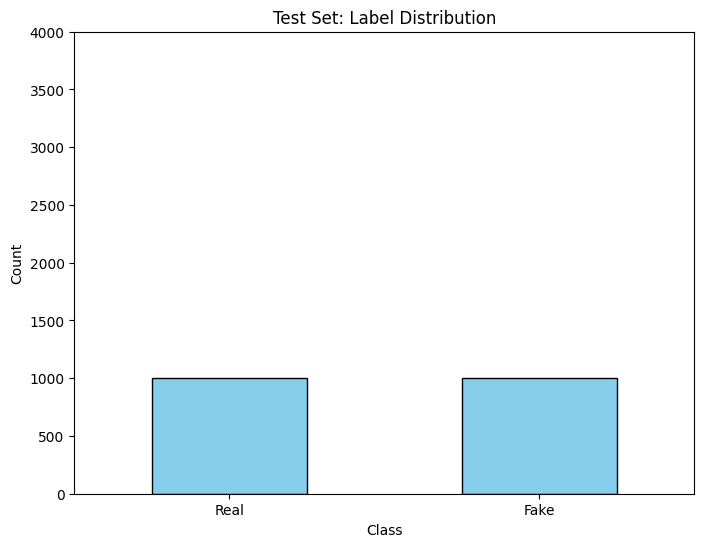

In [16]:
check_class_distribution(Y_test,"Test Set: Label Distribution")

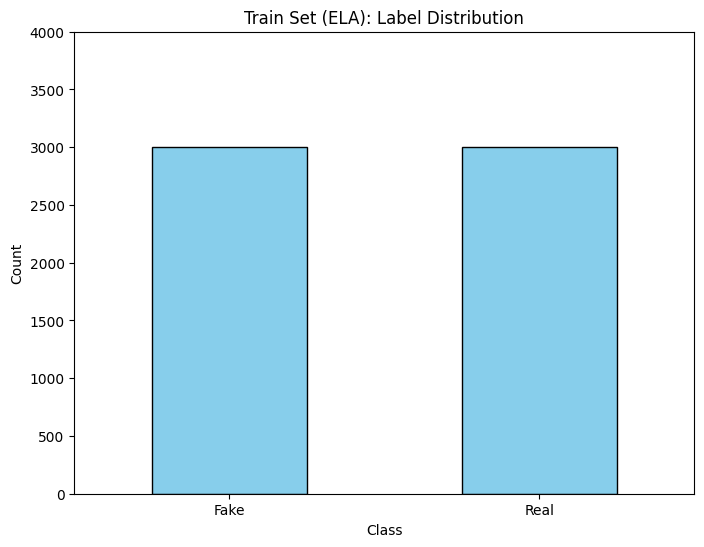

In [ ]:
check_class_distribution(Y_train_ela,"Train Set (ELA): Label Distribution")

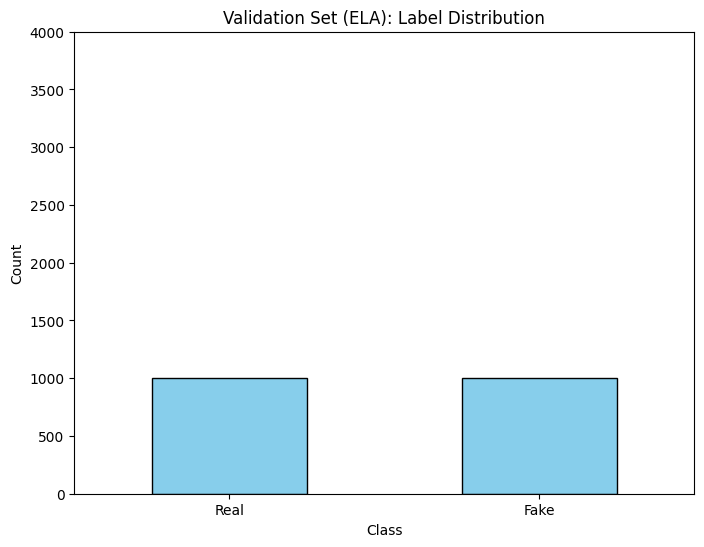

In [ ]:
check_class_distribution(Y_val_ela,"Validation Set (ELA): Label Distribution")

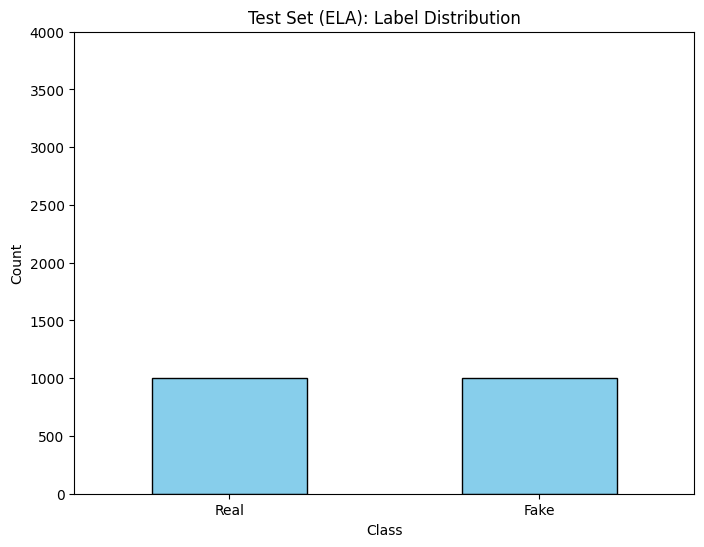

In [ ]:
check_class_distribution(Y_test_ela,"Test Set (ELA): Label Distribution")

# Modeling

## DenseNet-121

In [25]:
def densenet_model_build():
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    base_model.trainable = False


    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(), #dont put dropout after pooling
        layers.Dense(1024,activation='relu'), #best 1024, dont put regularization
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(5e-5)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

densenet_ela_model = densenet_model_build()
densenet_model = densenet_model_build()

In [26]:
densenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,089,154 (30.86 MB)

 Trainable params: 1,051,650 (4.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [27]:
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

callbacks = [lr_scheduler, early_stopping]

In [28]:
densenet_ela_history = densenet_ela_model.fit(X_train_ela, Y_train_ela,epochs=10,validation_data=(X_val_ela, Y_val_ela),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.5616 - loss: 0.6962 - val_accuracy: 0.7330 - val_loss: 0.5676 - learning_rate: 5.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - accuracy: 0.6735 - loss: 0.5971 - val_accuracy: 0.7465 - val_loss: 0.5417 - learning_rate: 5.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7052 - loss: 0.5667 - val_accuracy: 0.7515 - val_loss: 0.5288 - learning_rate: 5.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.7330 - loss: 0.5347 - val_accuracy: 0.6950 - val_loss: 0.5701 - learning_rate: 5.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.7434 - loss: 0.5249 - val_accuracy: 0.7555 - val_loss: 0.5191 - learning_rate: 5.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.7452 - loss: 0.5201 - val_accuracy: 0.7600 - val_loss: 0.5129 - learning_rate: 5.0000e-05
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 285s 2s/step - acc

In [29]:
densenet_ela_loss, densenet_ela_acc = densenet_ela_model.evaluate(X_test_ela, Y_test_ela)
print(f"Test Loss: {densenet_ela_loss}, Test Accuracy: {densenet_ela_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6735 - loss: 0.6288
Test Loss: 0.6374759078025818, Test Accuracy: 0.6700000166893005


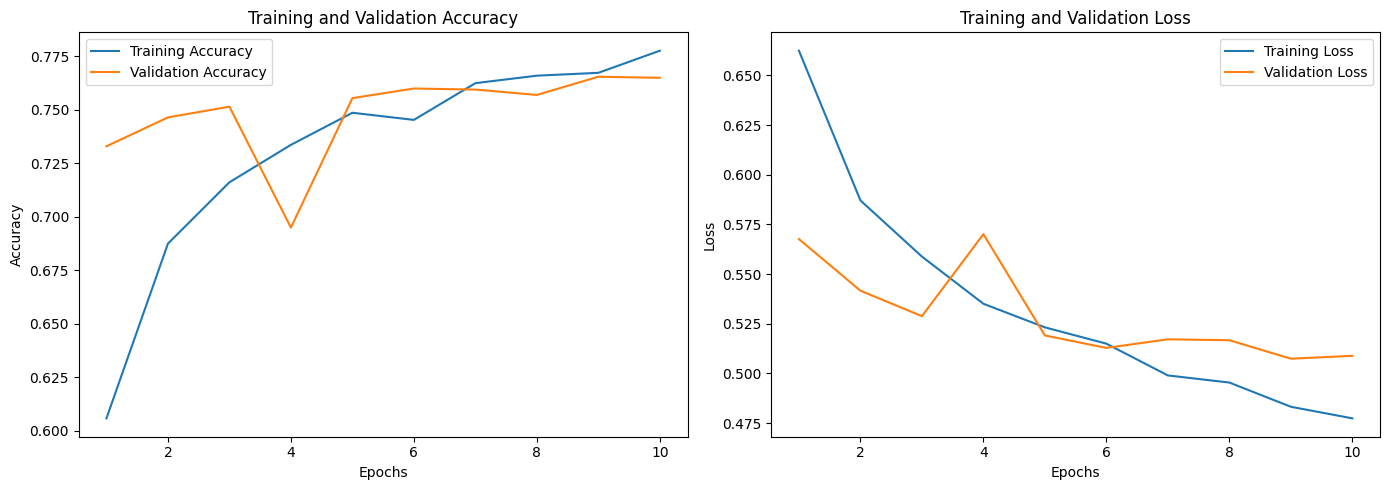

In [31]:
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot Accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_metrics(densenet_ela_history)


In [32]:
def evaluate_model(model, X_test, Y_test, class_names=["Real", "Fake"]):
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(Y_test, Y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print(classification_report(Y_test, Y_pred_classes, target_names=class_names))


63/63 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step


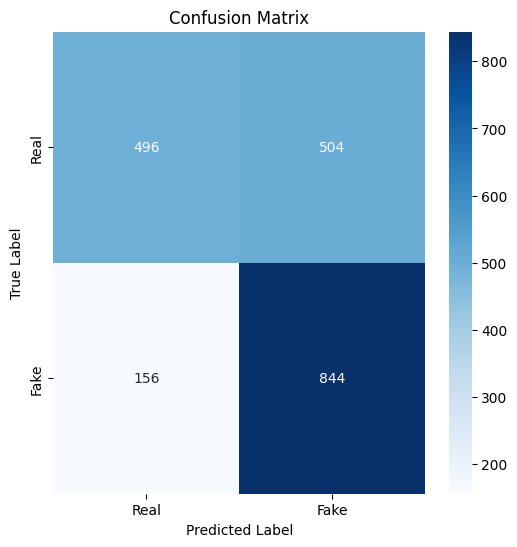

              precision    recall  f1-score   support

        Real       0.76      0.50      0.60      1000
        Fake       0.63      0.84      0.72      1000

    accuracy                           0.67      2000
   macro avg       0.69      0.67      0.66      2000
weighted avg       0.69      0.67      0.66      2000



In [33]:
evaluate_model(densenet_ela_model, X_test_ela, Y_test_ela)

In [34]:
densenet_history = densenet_model.fit(X_train, Y_train, epochs = 10, validation_data=(X_val, Y_val), callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.6997 - loss: 0.5657 - val_accuracy: 0.8220 - val_loss: 0.4096 - learning_rate: 5.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.8509 - loss: 0.3605 - val_accuracy: 0.8110 - val_loss: 0.4203 - learning_rate: 5.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.8787 - loss: 0.3030 - val_accuracy: 0.8475 - val_loss: 0.3500 - learning_rate: 5.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8861 - loss: 0.2850 - val_accuracy: 0.8435 - val_loss: 0.3573 - learning_rate: 5.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8964 - loss: 0.2648
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.8964 - loss: 0.2648 - val_accuracy: 0.8455 - val_loss: 0.3535 - learning_rate: 5.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 309s 2s/step - accuracy: 

In [35]:
densenet_loss, densenet_acc = densenet_model.evaluate(X_test, Y_test)
print(f"Test Loss: {densenet_loss}, Test Accuracy: {densenet_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7958 - loss: 0.4737
Test Loss: 0.450090229511261, Test Accuracy: 0.8044999837875366


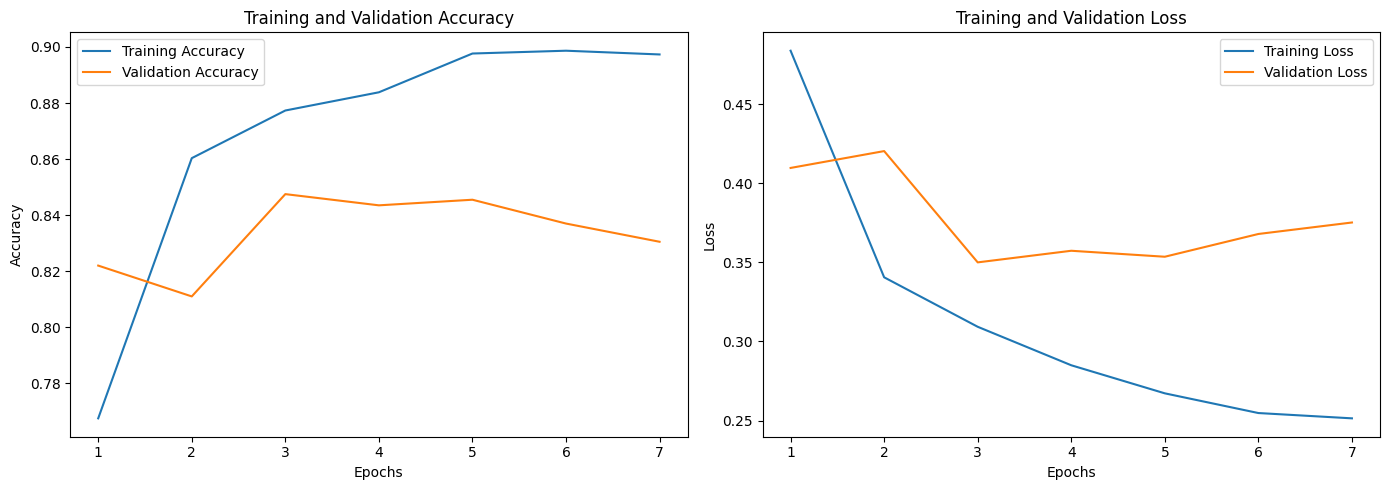

In [37]:
plot_metrics(densenet_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step


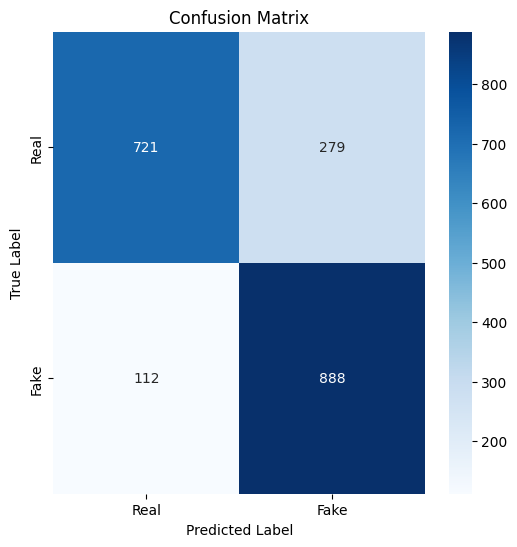

              precision    recall  f1-score   support

        Real       0.87      0.72      0.79      1000
        Fake       0.76      0.89      0.82      1000

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



In [38]:
evaluate_model(densenet_model, X_test, Y_test)

## InceptionV3

In [39]:
from tensorflow.keras.applications import InceptionV3

def inceptionv3_model_build():
    base_model = InceptionV3(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    base_model.trainable = False


    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(), 
        layers.Dense(1024,activation='relu'), 
        layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(5e-5)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

inceptionv3_model = inceptionv3_model_build()
inceptionv3_ela_model = inceptionv3_model_build()

In [40]:
inceptionv3_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,903,010 (91.18 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [41]:
inceptionv3_ela_history = inceptionv3_ela_model.fit(X_train_ela, Y_train_ela,epochs=10,validation_data=(X_val_ela, Y_val_ela),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 126s 642ms/step - accuracy: 0.6397 - loss: 0.6411 - val_accuracy: 0.7050 - val_loss: 0.5648 - learning_rate: 5.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 114s 605ms/step - accuracy: 0.7349 - loss: 0.5379 - val_accuracy: 0.7215 - val_loss: 0.5430 - learning_rate: 5.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 116s 617ms/step - accuracy: 0.7750 - loss: 0.4810 - val_accuracy: 0.7415 - val_loss: 0.5271 - learning_rate: 5.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 116s 618ms/step - accuracy: 0.7781 - loss: 0.4596 - val_accuracy: 0.7460 - val_loss: 0.5211 - learning_rate: 5.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 623ms/step - accuracy: 0.7967 - loss: 0.4469 - val_accuracy: 0.7435 - val_loss: 0.5287 - learning_rate: 5.0000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.7926 - loss: 0.4384
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 62

In [42]:
inc_ela_loss, inc_ela_acc = inceptionv3_ela_model.evaluate(X_test_ela, Y_test_ela)
print(f"Test Loss: {inc_ela_loss}, Test Accuracy: {inc_ela_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 450ms/step - accuracy: 0.6723 - loss: 0.6282
Test Loss: 0.6355341076850891, Test Accuracy: 0.6735000014305115


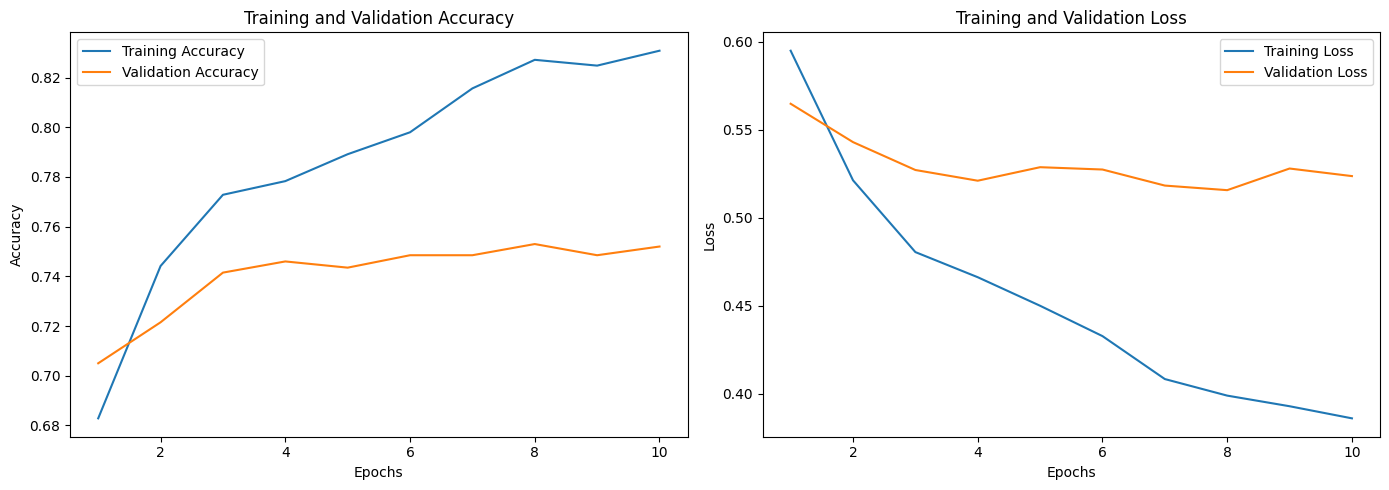

In [44]:
plot_metrics(inceptionv3_ela_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 474ms/step


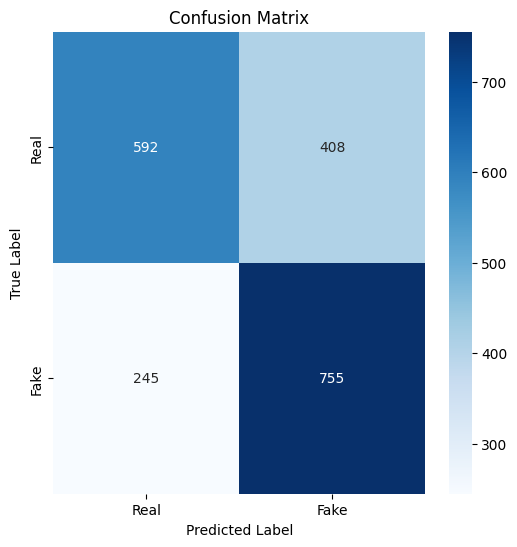

              precision    recall  f1-score   support

        Real       0.71      0.59      0.64      1000
        Fake       0.65      0.76      0.70      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.67      2000
weighted avg       0.68      0.67      0.67      2000



In [45]:
evaluate_model(inceptionv3_ela_model, X_test_ela, Y_test_ela)

In [46]:
inceptionv3_history = inceptionv3_model.fit(X_train, Y_train,epochs=10,validation_data=(X_val, Y_val),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 130s 646ms/step - accuracy: 0.7252 - loss: 0.5314 - val_accuracy: 0.8260 - val_loss: 0.3941 - learning_rate: 5.0000e-05
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 116s 617ms/step - accuracy: 0.8611 - loss: 0.3330 - val_accuracy: 0.8265 - val_loss: 0.3887 - learning_rate: 5.0000e-05
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 624ms/step - accuracy: 0.8848 - loss: 0.2830 - val_accuracy: 0.8160 - val_loss: 0.3991 - learning_rate: 5.0000e-05
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.8894 - loss: 0.2606
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 624ms/step - accuracy: 0.8894 - loss: 0.2606 - val_accuracy: 0.8070 - val_loss: 0.4224 - learning_rate: 5.0000e-05
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 117s 625ms/step - accuracy: 0.9109 - loss: 0.2323 - val_accuracy: 0.8375 - val_loss: 0.3624 - learning_rate: 2.5000e-05
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 123s 65

In [47]:
inc_loss, inc_acc = inceptionv3_model.evaluate(X_test, Y_test)
print(f"Test Loss: {inc_loss}, Test Accuracy: {inc_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 453ms/step - accuracy: 0.7914 - loss: 0.4761
Test Loss: 0.45562952756881714, Test Accuracy: 0.8015000224113464


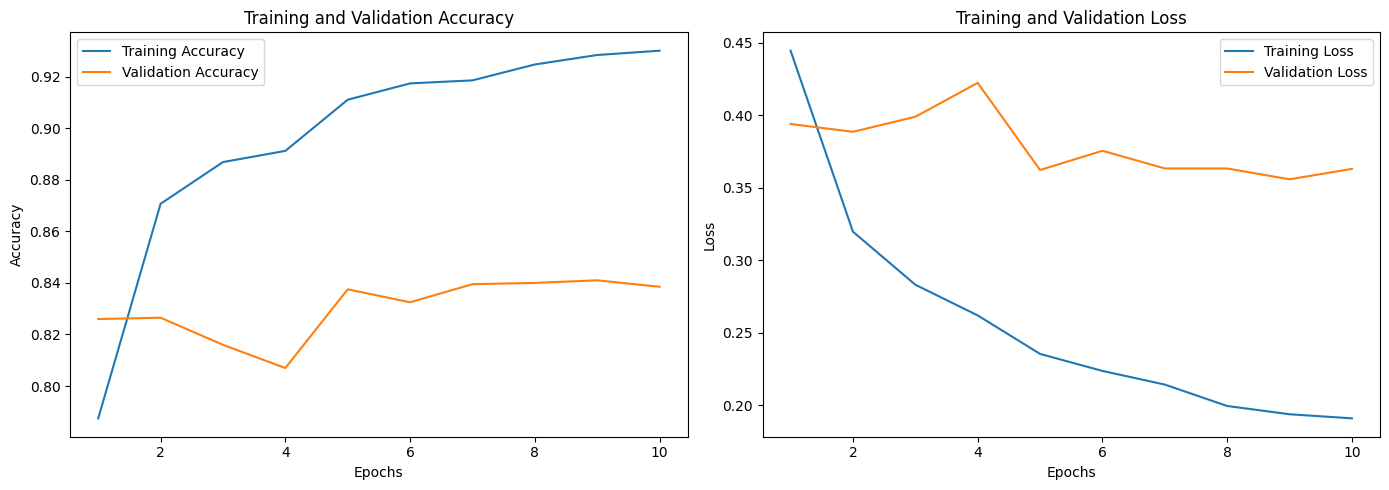

In [49]:
plot_metrics(inceptionv3_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 477ms/step


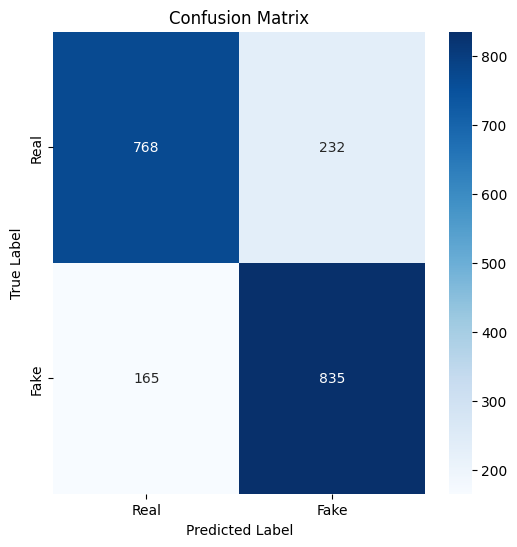

              precision    recall  f1-score   support

        Real       0.82      0.77      0.79      1000
        Fake       0.78      0.83      0.81      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



In [50]:
evaluate_model(inceptionv3_model, X_test, Y_test)

## Xception

In [51]:
from tensorflow.keras.applications import Xception

def xception_model_build():
    base_model = Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    base_model.trainable = False


    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(), 
        layers.Dense(1024,activation='relu'), 
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(1e-4)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

xception_model = xception_model_build()
xception_ela_model = xception_model_build()

In [52]:
xception_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,961,706 (87.59 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [53]:
xception_ela_history = xception_ela_model.fit(X_train_ela, Y_train_ela,epochs=10,validation_data=(X_val_ela, Y_val_ela),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.6284 - loss: 0.6381 - val_accuracy: 0.7100 - val_loss: 0.5606 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7341 - loss: 0.5366 - val_accuracy: 0.6975 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7449 - loss: 0.5166 - val_accuracy: 0.7145 - val_loss: 0.5524 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7719 - loss: 0.4855 - val_accuracy: 0.7215 - val_loss: 0.5487 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.7738 - loss: 0.4816 - val_accuracy: 0.7255 - val_loss: 0.5400 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.7897 - loss: 0.4654 - val_accuracy: 0.7170 - val_loss: 0.5604 - learning_rate: 1.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accur

In [54]:
xc_ela_loss, xc_ela_acc = xception_ela_model.evaluate(X_test_ela, Y_test_ela)
print(f"Test Loss: {xc_ela_loss}, Test Accuracy: {xc_ela_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6782 - loss: 0.6496
Test Loss: 0.6462850570678711, Test Accuracy: 0.6669999957084656


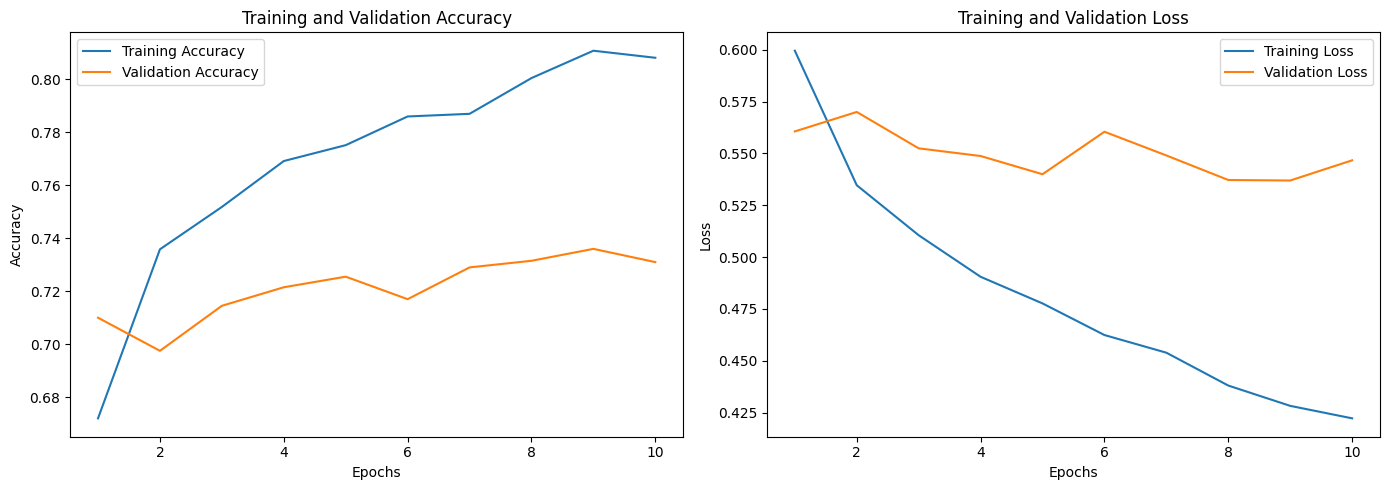

In [56]:
plot_metrics(xception_ela_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step


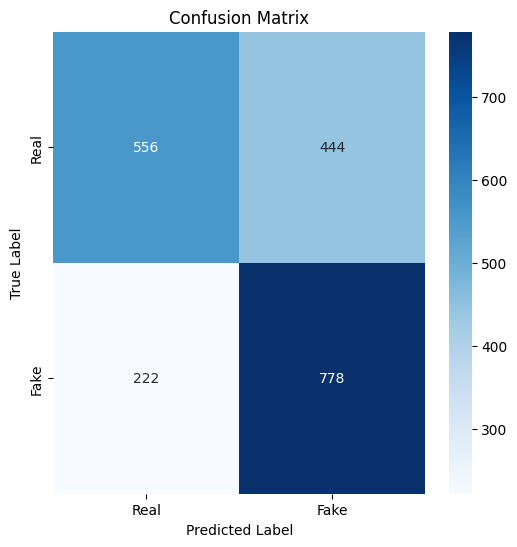

              precision    recall  f1-score   support

        Real       0.71      0.56      0.63      1000
        Fake       0.64      0.78      0.70      1000

    accuracy                           0.67      2000
   macro avg       0.68      0.67      0.66      2000
weighted avg       0.68      0.67      0.66      2000



In [57]:
evaluate_model(xception_ela_model, X_test_ela, Y_test_ela)

In [58]:
xception_history = xception_model.fit(X_train, Y_train,epochs=10,validation_data=(X_val, Y_val),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.6927 - loss: 0.5654 - val_accuracy: 0.7695 - val_loss: 0.4803 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 0.8301 - loss: 0.3820 - val_accuracy: 0.7480 - val_loss: 0.5182 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8634 - loss: 0.3233 - val_accuracy: 0.7975 - val_loss: 0.4501 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 273s 1s/step - accuracy: 0.8805 - loss: 0.2956 - val_accuracy: 0.8300 - val_loss: 0.3916 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.8920 - loss: 0.2611 - val_accuracy: 0.8180 - val_loss: 0.4122 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9001 - loss: 0.2502
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 272s 1s/step - accuracy: 

In [59]:
xc_loss, xc_acc = xception_model.evaluate(X_test, Y_test)
print(f"Test Loss: {xc_loss}, Test Accuracy: {xc_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7697 - loss: 0.4892
Test Loss: 0.494488924741745, Test Accuracy: 0.777999997138977


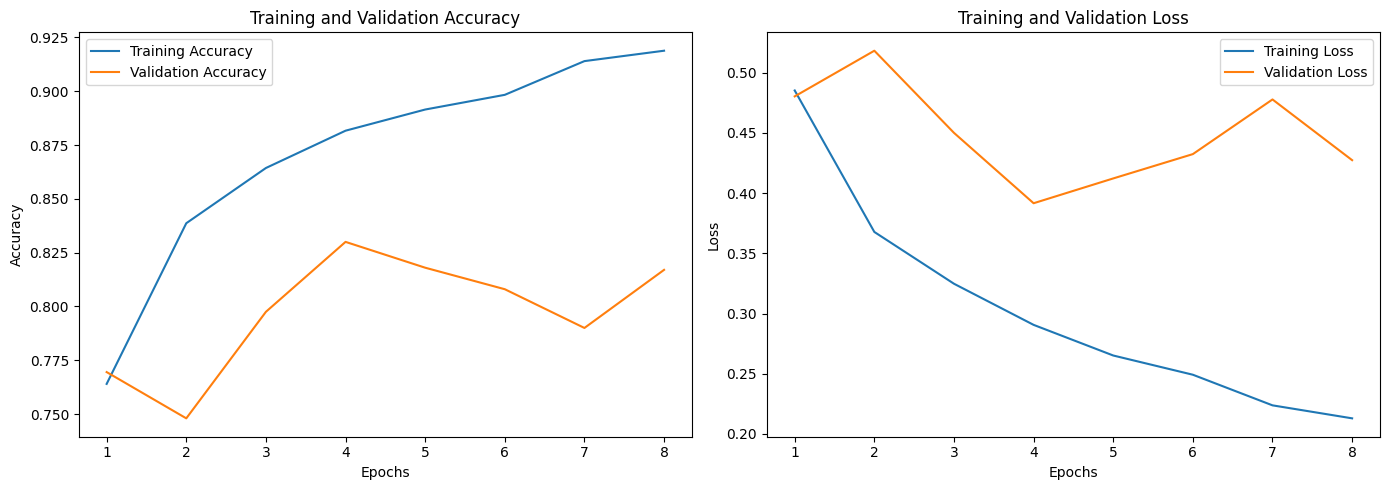

In [61]:
plot_metrics(xception_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


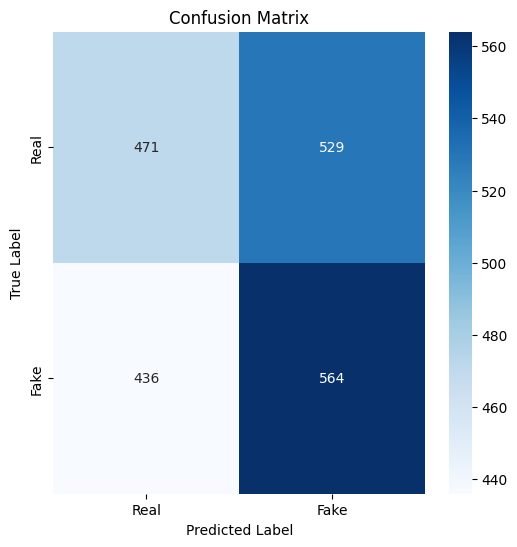

              precision    recall  f1-score   support

        Real       0.52      0.47      0.49      1000
        Fake       0.52      0.56      0.54      1000

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



In [62]:
evaluate_model(xception_ela_model, X_test, Y_test)

## MobileNetV3

In [64]:
from tensorflow.keras.applications import MobileNetV3Small

def mobilenetv3_model_build():
    base_model = MobileNetV3Small(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    base_model.trainable = False


    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(), 
        layers.Dense(1024,activation='relu'), 
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(1e-4)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

mobilenetv3_model = mobilenetv3_model_build()
mobilenetv3_ela_model = mobilenetv3_model_build()

In [65]:
mobilenetv3_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       590,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,532,018 (5.84 MB)

 Trainable params: 592,898 (2.26 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [66]:
mobilenetv3_ela_history = mobilenetv3_ela_model.fit(X_train_ela, Y_train_ela,epochs=10,validation_data=(X_val_ela, Y_val_ela),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - accuracy: 0.4911 - loss: 0.7126 - val_accuracy: 0.5000 - val_loss: 0.6930 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.5000 - loss: 0.7067 - val_accuracy: 0.5000 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 132ms/step - accuracy: 0.4995 - loss: 0.7029 - val_accuracy: 0.5005 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.5025 - loss: 0.7000 - val_accuracy: 0.5765 - val_loss: 0.6912 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.5042 - loss: 0.6992 - val_accuracy: 0.5000 - val_loss: 0.6921 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.5114 - loss: 0.6981
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/ste

In [67]:
mobilenetv3_ela_loss, mobilenetv3_ela_acc = mobilenetv3_ela_model.evaluate(X_test_ela, Y_test_ela)
print(f"Test Loss: {mobilenetv3_ela_loss}, Test Accuracy: {mobilenetv3_ela_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5480 - loss: 0.6915
Test Loss: 0.6913625001907349, Test Accuracy: 0.5540000200271606


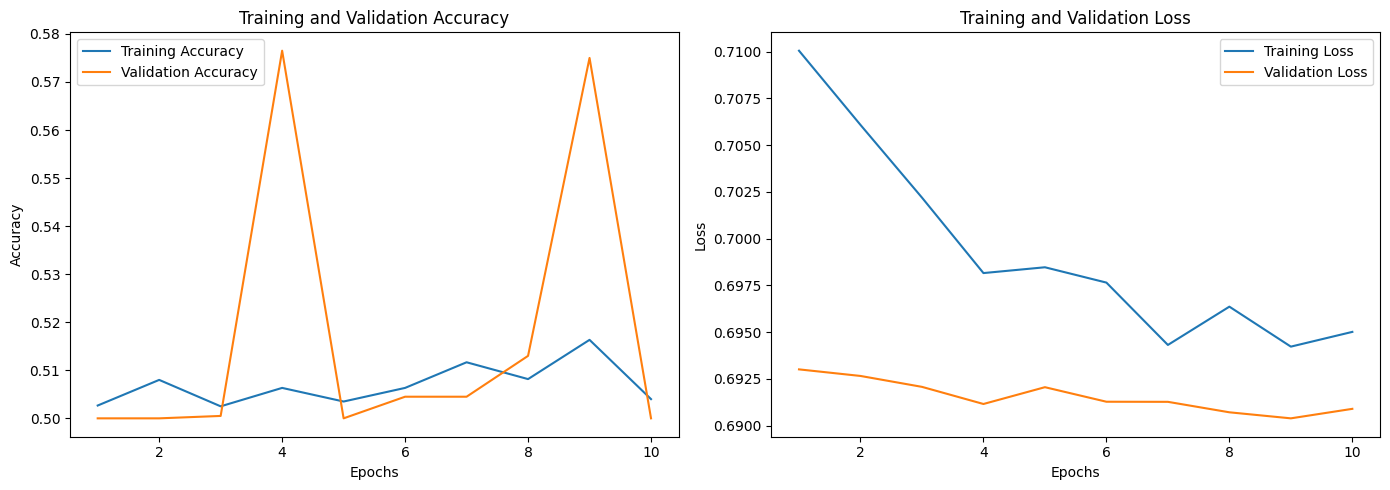

In [68]:
plot_metrics(mobilenetv3_ela_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step


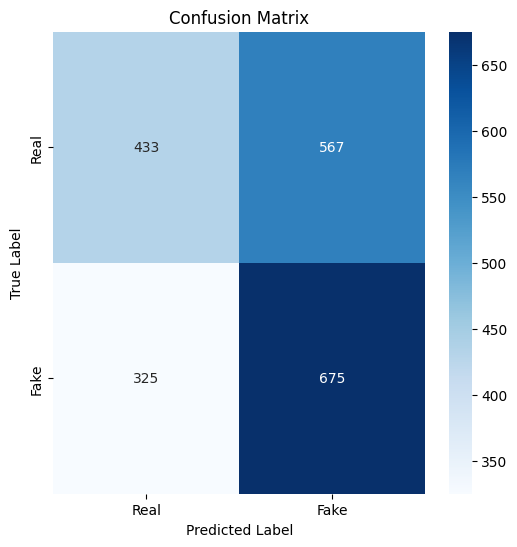

              precision    recall  f1-score   support

        Real       0.57      0.43      0.49      1000
        Fake       0.54      0.68      0.60      1000

    accuracy                           0.55      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.56      0.55      0.55      2000



In [69]:
evaluate_model(mobilenetv3_ela_model, X_test_ela, Y_test_ela)

In [70]:
mobilenetv3_history = mobilenetv3_model.fit(X_train, Y_train,epochs=10,validation_data=(X_val, Y_val),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 179ms/step - accuracy: 0.4944 - loss: 0.7188 - val_accuracy: 0.5100 - val_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 129ms/step - accuracy: 0.5157 - loss: 0.7013 - val_accuracy: 0.5205 - val_loss: 0.6900 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.5115 - loss: 0.6972 - val_accuracy: 0.5000 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.5130 - loss: 0.6968 - val_accuracy: 0.5860 - val_loss: 0.6865 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 125ms/step - accuracy: 0.5380 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6892 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 127ms/step - accuracy: 0.5464 - loss: 0.6880 - val_accuracy: 0.5255 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 12

In [71]:
mobilenetv3_loss, mobilenetv3_acc = mobilenetv3_model.evaluate(X_test, Y_test)
print(f"Test Loss: {mobilenetv3_loss}, Test Accuracy: {mobilenetv3_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5269 - loss: 0.6922
Test Loss: 0.6898650527000427, Test Accuracy: 0.5325000286102295


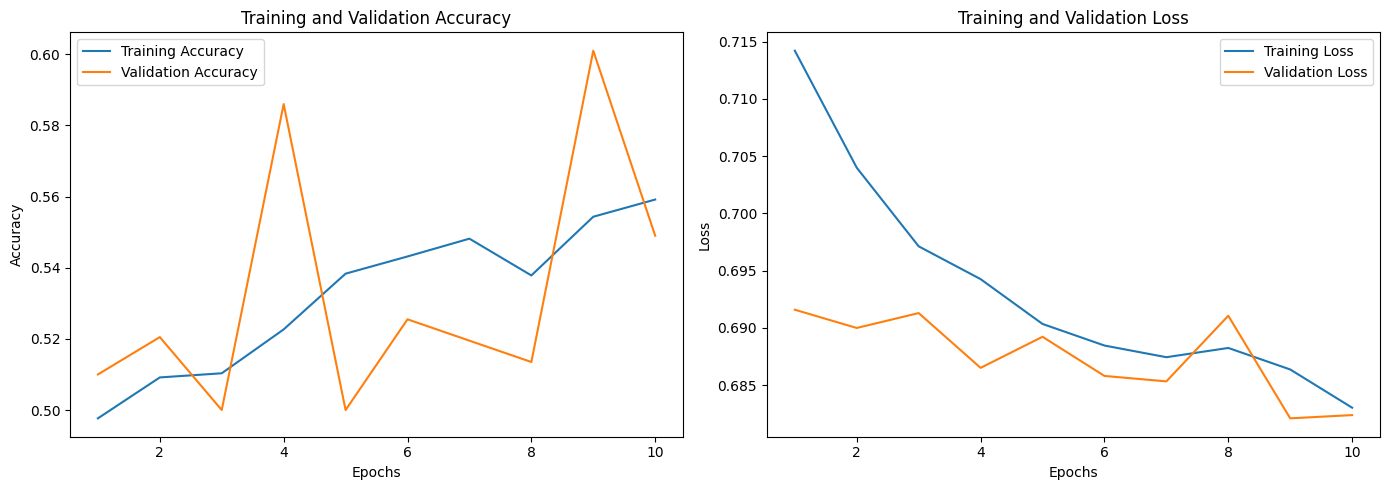

In [72]:
plot_metrics(mobilenetv3_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step


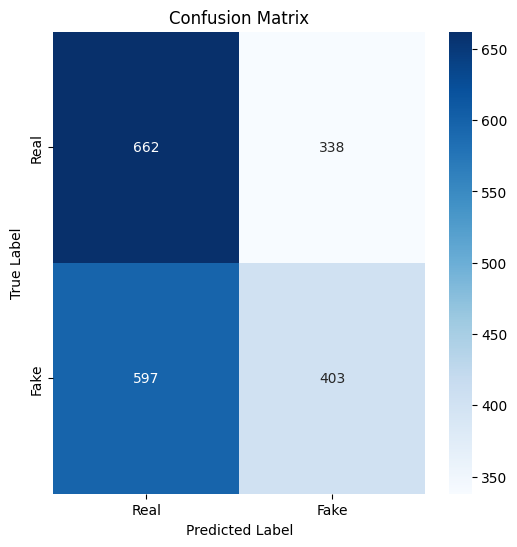

              precision    recall  f1-score   support

        Real       0.53      0.66      0.59      1000
        Fake       0.54      0.40      0.46      1000

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.52      2000
weighted avg       0.53      0.53      0.52      2000



In [73]:
evaluate_model(mobilenetv3_model, X_test, Y_test)

## VGG-16

In [74]:
from tensorflow.keras.applications import VGG16

def vgg16_model_build():
    base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    
    base_model.trainable = False


    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        base_model,
        layers.GlobalAveragePooling2D(), 
        layers.Dense(1024,activation='relu'), 
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    optimizer = keras.optimizers.Adam(1e-4)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

vgg16_model = vgg16_model_build()
vgg16_ela_model = vgg16_model_build()

In [75]:
vgg16_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,242,050 (58.14 MB)

 Trainable params: 527,362 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
vgg16_ela_history = vgg16_ela_model.fit(X_train_ela, Y_train_ela,epochs=10,validation_data=(X_val_ela, Y_val_ela),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.4947 - loss: 0.7490 - val_accuracy: 0.4975 - val_loss: 0.6869 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 460s 2s/step - accuracy: 0.5320 - loss: 0.7106 - val_accuracy: 0.6185 - val_loss: 0.6682 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.5304 - loss: 0.7013 - val_accuracy: 0.6115 - val_loss: 0.6624 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.5502 - loss: 0.6937 - val_accuracy: 0.5590 - val_loss: 0.6676 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 458s 2s/step - accuracy: 0.5673 - loss: 0.6826 - val_accuracy: 0.6085 - val_loss: 0.6548 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.5850 - loss: 0.6737 - val_accuracy: 0.6710 - val_loss: 0.6488 - learning_rate: 1.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - acc

In [77]:
vgg16_ela_loss, vgg16_ela_acc = vgg16_ela_model.evaluate(X_test_ela, Y_test_ela)
print(f"Test Loss: {vgg16_ela_loss}, Test Accuracy: {vgg16_ela_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6012 - loss: 0.6663
Test Loss: 0.6669849753379822, Test Accuracy: 0.6010000109672546


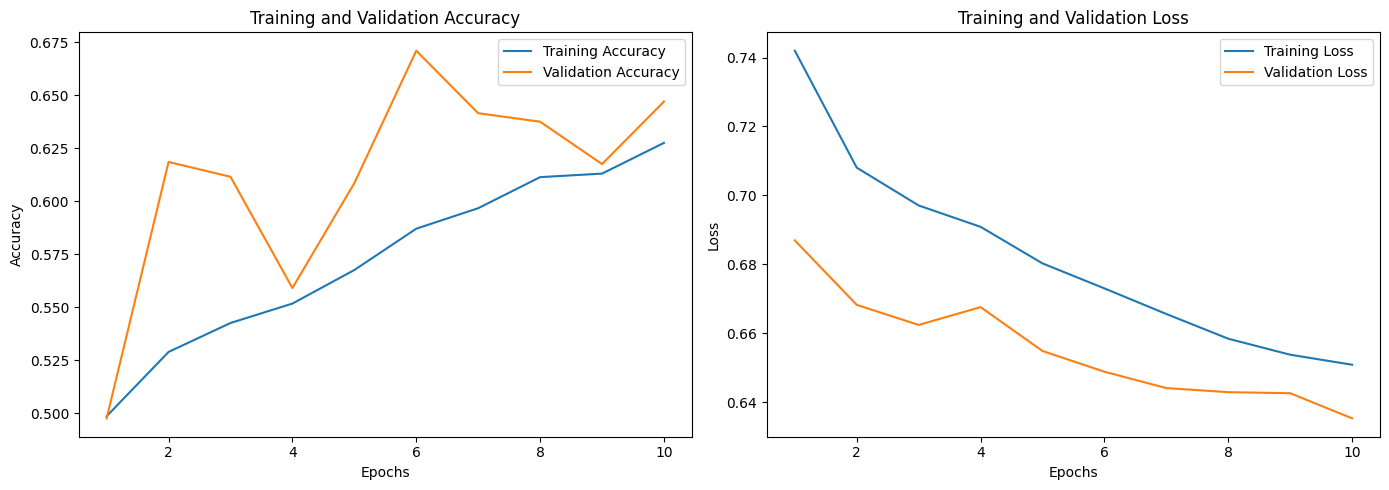

In [78]:
plot_metrics(vgg16_ela_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step


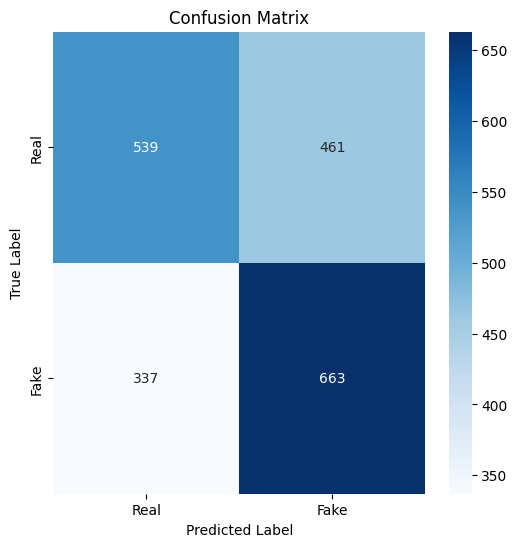

              precision    recall  f1-score   support

        Real       0.62      0.54      0.57      1000
        Fake       0.59      0.66      0.62      1000

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



In [79]:
evaluate_model(vgg16_ela_model, X_test_ela, Y_test_ela)

In [80]:
vgg16_history = vgg16_model.fit(X_train, Y_train,epochs=10,validation_data=(X_val, Y_val),callbacks=callbacks)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 457s 2s/step - accuracy: 0.5907 - loss: 0.6665 - val_accuracy: 0.8185 - val_loss: 0.4815 - learning_rate: 1.0000e-04
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7826 - loss: 0.4788 - val_accuracy: 0.8325 - val_loss: 0.4092 - learning_rate: 1.0000e-04
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.8228 - loss: 0.4024 - val_accuracy: 0.8430 - val_loss: 0.3748 - learning_rate: 1.0000e-04
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 0.8472 - loss: 0.3645 - val_accuracy: 0.8410 - val_loss: 0.3644 - learning_rate: 1.0000e-04
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 444s 2s/step - accuracy: 0.8501 - loss: 0.3545 - val_accuracy: 0.8420 - val_loss: 0.3648 - learning_rate: 1.0000e-04
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8534 - loss: 0.3489
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 445s 2s/step - accuracy: 

In [81]:
vgg16_loss, vgg16_acc = vgg16_model.evaluate(X_test, Y_test)
print(f"Test Loss: {vgg16_loss}, Test Accuracy: {vgg16_acc}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7921 - loss: 0.4574
Test Loss: 0.4464917480945587, Test Accuracy: 0.8004999756813049


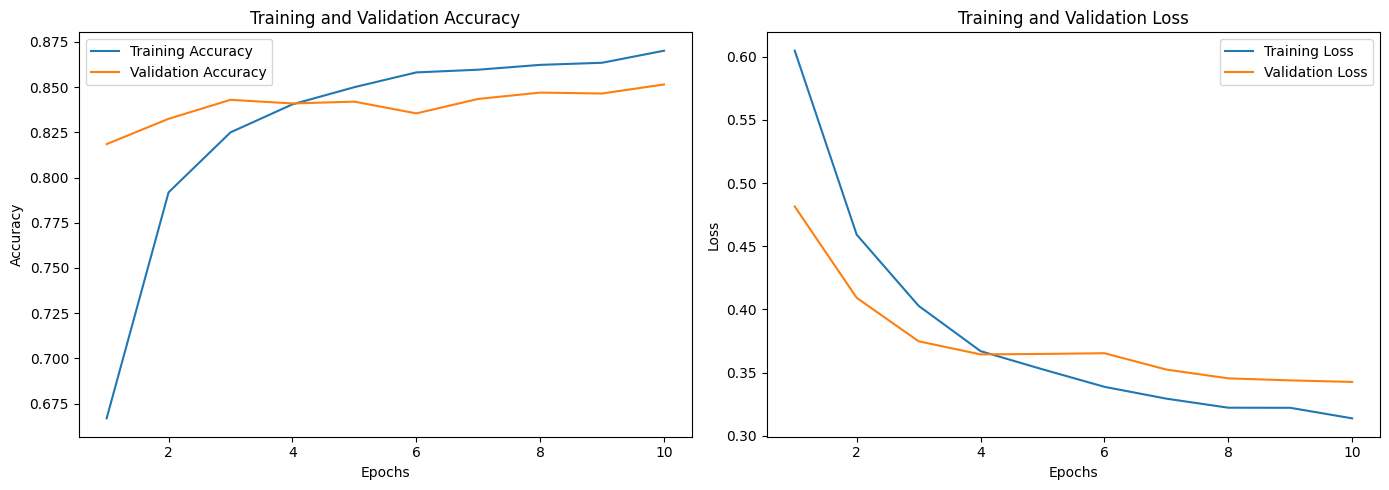

In [82]:
plot_metrics(vgg16_history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step


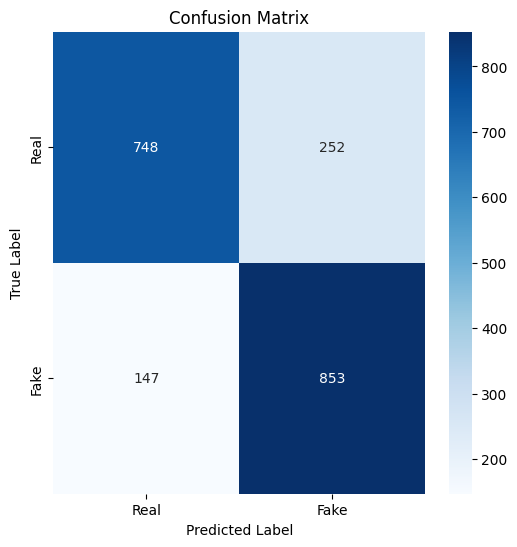

              precision    recall  f1-score   support

        Real       0.84      0.75      0.79      1000
        Fake       0.77      0.85      0.81      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



In [83]:
evaluate_model(vgg16_model, X_test, Y_test)

## Model Test

In [87]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import img_to_array

def predict_image(model, img_path, class_names=["Real", "Fake"]):
    img = ela(img_path)
    
    img_resized = img.resize((224, 224))  
    img_array = img_to_array(img_resized)  
    img_array = img_array.astype('float32') / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=-1)
    predicted_label = class_names[predicted_class[0]]
    confidence = predictions[0][predicted_class[0]]  
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.show()
    
    return predicted_label, confidence


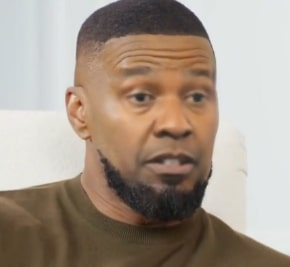

In [79]:
Image.open('dataset/deepfake1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


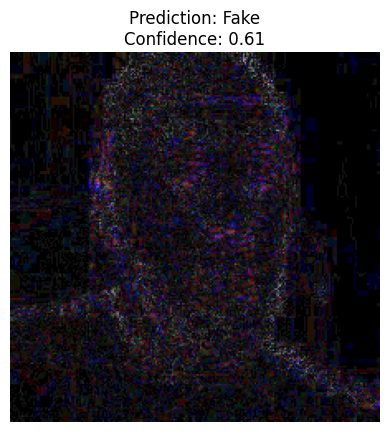

('Fake', np.float32(0.6074985))

In [88]:
predict_image(densenet_model, 'dataset/deepfake1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


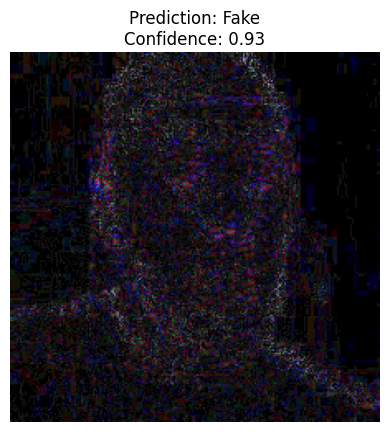

('Fake', np.float32(0.9319454))

In [89]:
predict_image(inceptionv3_model, 'dataset/deepfake1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


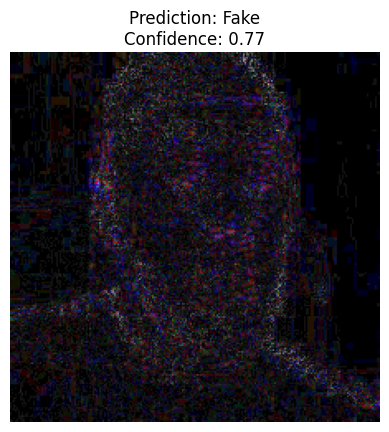

('Fake', np.float32(0.7720853))

In [90]:
predict_image(xception_model, 'dataset/deepfake1.jpg')